In [1]:
import time
import torch
import numpy as np
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import deepwave
%matplotlib inline

import sys
sys.path.append("../")

In [2]:
device=torch.device('cuda')

# Medium dimensions
nx=500
dx=5.0
nz=251
dz=5.0

# Sources
n_sources_per_shot=1
n_shots=100
d_source=5
first_source=0
source_depth=0

# Receivers
n_receivers_per_shot=250
d_receiver=2
first_receiver=0
receiver_depth=0

# Recording time
nt=500
dt=0.004
ot=0
freq=25
peak_time=1/freq
fs=1/dt

# Source_locations
source_locations=torch.zeros(n_shots, n_sources_per_shot, 2,
                               dtype=torch.long, device=device)
source_locations[..., 1]=source_depth
source_locations[:, 0, 0]=(torch.arange(n_shots) * d_source +
                             first_source)

# Receiver_locations
receiver_locations=torch.zeros(n_shots, n_receivers_per_shot, 2,
                                 dtype=torch.long, device=device)
receiver_locations[..., 1]=receiver_depth
receiver_locations[:, :, 0]=(
    (torch.arange(n_receivers_per_shot) * d_receiver +
     first_receiver)
    .repeat(n_shots, 1)
)

# Source_amplitudes
source_amplitudes=(
    (deepwave.wavelets.ricker(freq, nt, dt, peak_time))
    .repeat(n_shots, n_sources_per_shot, 1).to(device)
)

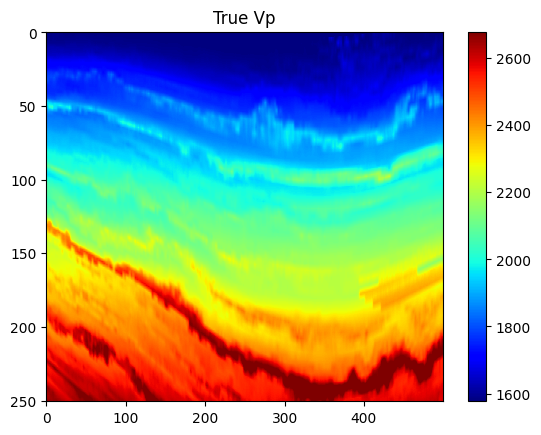

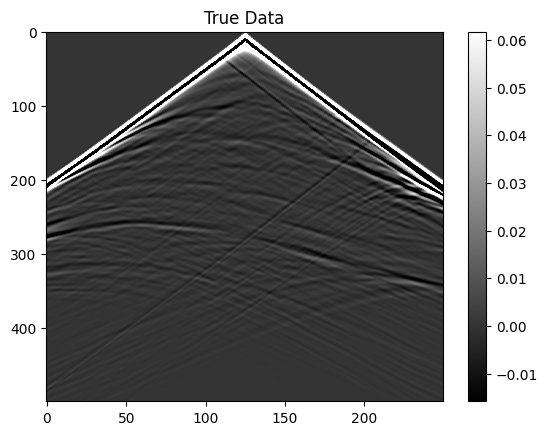

In [3]:
# Load the true model
v_true=torch.from_numpy(np.fromfile('model.bin', np.float32).reshape(nx, nz)).to(device)
m_vmin, m_vmax=np.percentile(v_true.cpu().numpy(), [2,98]) 

plt.figure()
plt.imshow(v_true.T.cpu().numpy(), vmin=m_vmin, vmax=m_vmax, cmap='jet', aspect='auto')
plt.colorbar()
plt.title('True Vp');

# Generate data
observed_data=deepwave.scalar(
    v_true, [dz,dx], dt,
    source_amplitudes=source_amplitudes,
    source_locations=source_locations,
    receiver_locations=receiver_locations,
    pml_freq=freq,
)
d_vmin, d_vmax=np.percentile(observed_data[-1].cpu().numpy(), [2,98]) 

plt.figure()
plt.imshow(observed_data[-1][n_shots//2].T.detach().cpu().numpy(), vmin=d_vmin, vmax=d_vmax, cmap='gray', aspect='auto')
plt.colorbar()
plt.title('True Data');

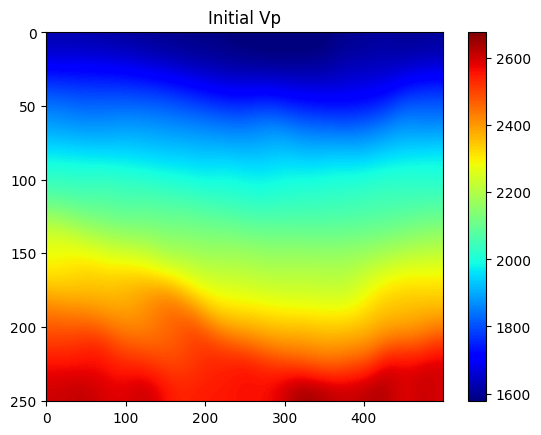

In [4]:
# Create initial velocity model
v_init=(torch.tensor(1/gaussian_filter(1/v_true.detach().cpu().numpy(), 15)).to(device))
v=v_init.clone().requires_grad_(True)

plt.figure()
plt.imshow(v_init.T.cpu().numpy(), vmin=m_vmin, vmax=m_vmax, cmap='jet', aspect='auto')
plt.colorbar()
plt.title('Initial Vp');

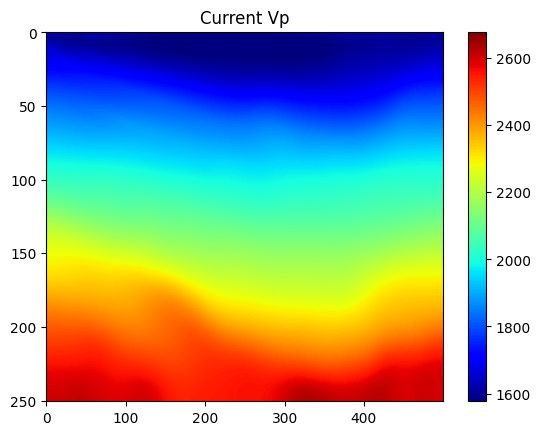

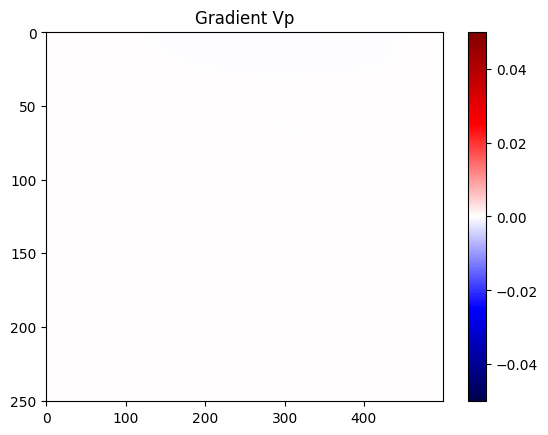

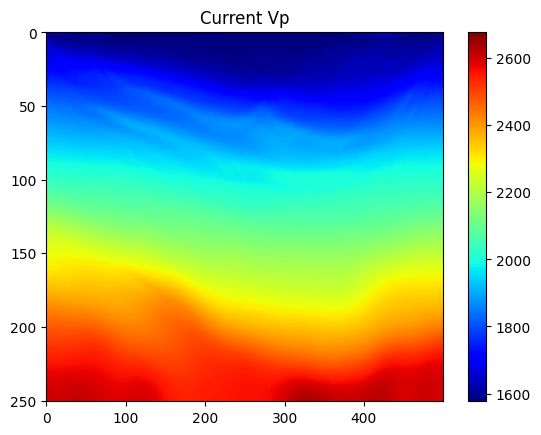

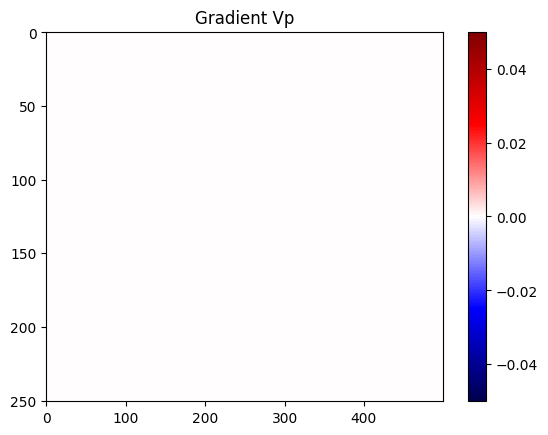

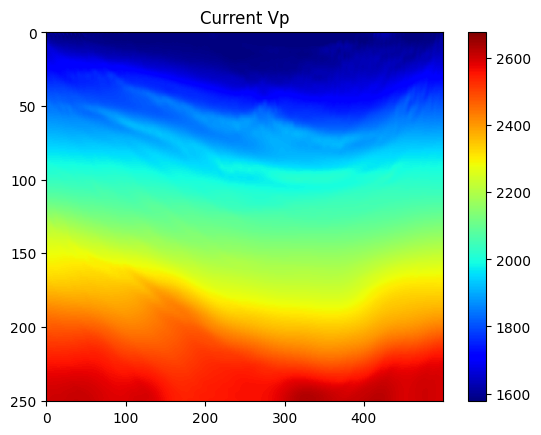

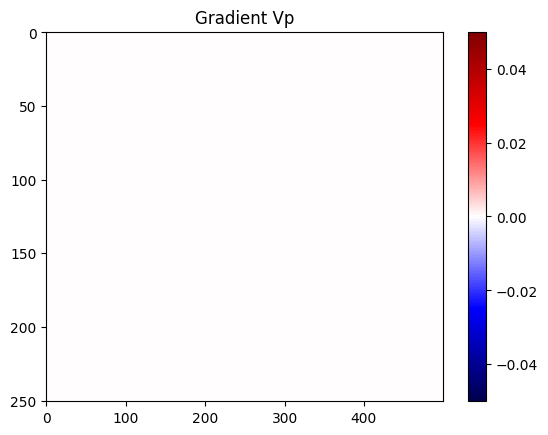

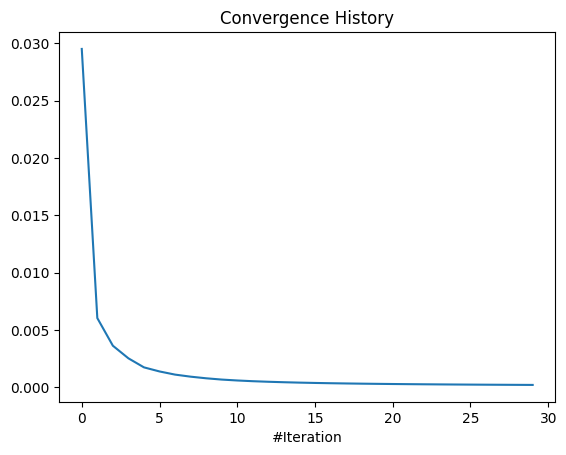

In [5]:
# Setup optimiser to perform inversion
optimiser=torch.optim.Adam([v], lr=1e1)
loss_fn=torch.nn.MSELoss() 

# Run optimisation/inversion
n_iterations=30
n_batches=10

epoch_loss=[]

for epoch in range(n_iterations):
    running_loss=0
    
    # Perform computation per batch
    for it in range(0, n_shots, n_batches):
        optimiser.zero_grad()
        out=deepwave.scalar(
            v, dx, dt,
            source_amplitudes=source_amplitudes[it:it+n_batches, :, :],
            source_locations=source_locations[it:it+n_batches, :, :],
            receiver_locations=receiver_locations[it:it+n_batches, :, :],
            pml_freq=freq,
        )
        loss=loss_fn(out[-1], observed_data[-1][it:it+n_batches, :, :])
        loss.backward()
        torch.nn.utils.clip_grad_value_(
            v,
            torch.quantile(v.grad.detach().abs(), 0.98)
        )
        optimiser.step()
        running_loss+=loss.item()
    
    epoch_loss.append(running_loss)
    
    # Plotting every 10 iterations 
    if epoch % 10 == 0:
        plt.figure()
        plt.imshow(v.T.cpu().detach().numpy(), vmin=m_vmin, vmax=m_vmax, cmap='jet', aspect='auto')
        plt.colorbar()
        plt.title('Current Vp');
        plt.show()
    
        plt.figure()
        plt.imshow(v.grad.T.cpu().detach().numpy(), cmap='seismic',vmin=-0.05,vmax=0.05, aspect='auto')
        plt.colorbar()
        plt.title('Gradient Vp');
        plt.show()
        
# Plot convergence 
plt.figure()
plt.plot(np.arange(n_iterations),np.array(epoch_loss))
plt.xlabel('#Iteration')
plt.title('Convergence History');